In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

sns.set()
sns.set_style("ticks")
# sns.set(rc={'axes.facecolor':'#1E1E1E', 'figure.facecolor':'#1E1E1E'})

import tskit
from collections import defaultdict

from chromwindow import window
from switchprobs import sample_switch_sets, cut_intervals

# # scale down size of default plots
# sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]
97


/Users/kmt/miniconda3/envs/switch-probs/lib/python3.8/site-packages/tskit/drawing.py:1311: FutureWarning: tree_height_scale is deprecated; use time_scale instead
  warnings.warn(


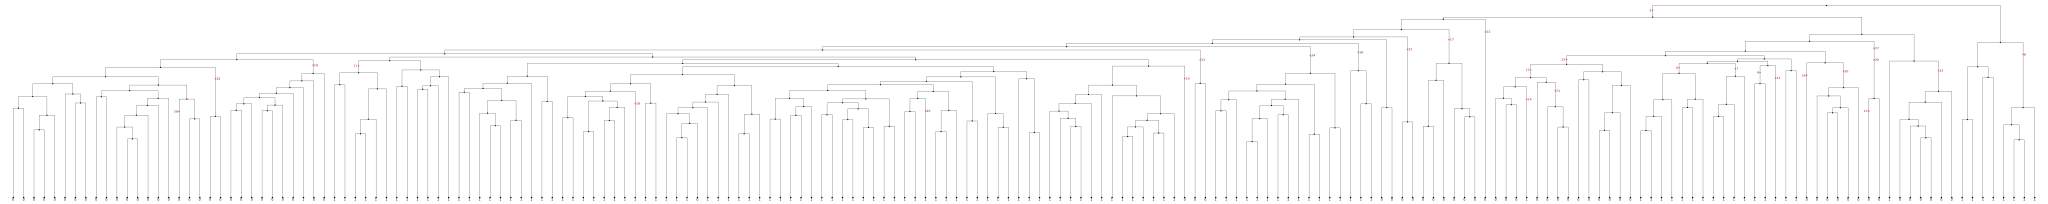

In [64]:
tree_seq = tskit.load('/Users/kmt/Downloads/chromX_tskit.trees')
# for tree in tree_seq.trees():
#     print(tree)
#     break

print(tree_seq.samples())
print(195 // 2)
sample_df = pd.read_csv('/Users/kmt/Downloads/all_females_8cluster.sample', sep=' ')
sample_df.head()

labels = []
north_pops = ['Papio', 'Hamadryas', 'Ethiopian Olive',  'Tanzanian Olive']
for sample_idx in tree_seq.samples():
    labels.append(int(sample_df.loc[sample_idx//2, 'POP'] in north_pops))
len(labels)

#labels = [0] * len(labels)

ts = tree_seq.trees()
tree = next(ts)
tree = next(ts)
tree.draw_svg(size=(10000, 1000), tree_height_scale='log_time',
node_labels=dict(zip(range(len(labels)), labels))
 )


In [70]:


# tree = tskit.Tree.generate_random_binary(9, random_seed=3)

# tree = tskit.Tree.generate_balanced(9, arity=2)
# labels = np.array([0, 0, 0, 0, 1, 1, 1, 1, 0])

# n = 20
# tree = tskit.Tree.generate_balanced(n, arity=2)
# leaves = list(range(n))
# labels = np.array([0] * 10 + [1] * 10)

# # for i in range(0, 20, 2):
# #     labels[i] = 1

# # labels[0] = 1

# labels[5] = 1
# labels[6] = 1

# tree = tskit.Tree.generate_balanced(5, arity=2)
# labels = np.array([1, 1, 0, 1, 1])

# print(tree.draw_text())

labels = []
north_pops = ['Papio', 'Hamadryas', 'Ethiopian Olive',  'Tanzanian Olive']
for sample_idx in tree_seq.samples():
    labels.append(int(sample_df.loc[sample_idx//2, 'POP'] in north_pops))

nr_trees = 1000

records = list()

for tree in tree_seq.trees():

    if not nr_trees:
        break
    nr_trees -= 1


    tree_start_pos, tree_end_pos = tree.interval

    # part_fun = partial(fun, switch_rate=0.001,
    #    left_child_array=tree.left_child_array,
    #    right_child_array=tree.right_child_array, 
    #    parent_array=tree.parent_array,
    #    num_children_array=tree.num_children_array)
    # part_fun = partial(fun, switch_rate=0.001, tree=tree)

    # print(np.array(range(len(labels))))
    # print(labels)

    samples = sample_switch_sets(tree, labels, n_samples=100, switch_rate=0.00001)
    # for val, interv, key in samples:
    #     print(val, interv, key)

    intervals = []
    for val, interv, key in samples:
        for start, end, label in interv:
            intervals.append([np.log10(start), np.log10(end), key, label])
    intervals = sorted(intervals)


    @window(size=0.1)
    def switches(df):
        return df.switches.mean()

    df = pd.DataFrame().from_records(intervals, columns=['start', 'end', 'switches', 'label'])
    binned_intervals = df.groupby('label').apply(switches).reset_index(level=0)
    bins = defaultdict(float)
    for tup in binned_intervals.itertuples():
        bins[(tup.start, tup.end, tup.label)] += tup.switches

    # binned_intervals = cut_intervals(intervals, windowsize=2)
    # bins = defaultdict(float)
    # for start, end, prob, label in binned_intervals:
    #     bins[(start, end, label)] += prob

    mrca_tree = tree.time(tree.root)
    mrca_0 = tree.time(tree.mrca(*[x for x in sample_df.index if labels[x] == 0]))
    mrca_1 = tree.time(tree.mrca(*[x for x in sample_df.index if labels[x] == 1]))

    for key in sorted(bins.keys()):
        records.append((tree_start_pos, tree_end_pos, *key, round(bins[key], 5), mrca_tree, mrca_0, mrca_1))

df = pd.DataFrame().from_records(records,
    columns=['start_pos', 'end_pos', 'start_time', 'end_time', 'label', 'switches', 'mrca_tree', 'mrca_0', 'mrca_1'])
df

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_93413/838255008.py:59: RuntimeWarning: divide by zero encountered in log10
  intervals.append([np.log10(start), np.log10(end), key, label])
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_93413/838255008.py:59: RuntimeWarning: divide by zero encountered in log10
  intervals.append([np.log10(start), np.log10(end), key, label])
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_93413/838255008.py:59: RuntimeWarning: divide by zero encountered in log10
  intervals.append([np.log10(start), np.log10(end), key, label])
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_93413/838255008.py:59: RuntimeWarning: divide by zero encountered in log10
  intervals.append([np.log10(start), np.log10(end), key, label])
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_93413/838255008.py:59: RuntimeWarning: divide by zero encountered in log10
  intervals.append([np.log10(start), np.log10(end), key, label])
/var/

,start_pos,end_pos,start_time,end_time,label,switches,mrca_tree,mrca_0,mrca_1
0,0.0,71983.0,0.0,0.1,0,0.00989,38808.378906,38808.378906,38808.378906
1,0.0,71983.0,0.0,0.1,1,0.00987,38808.378906,38808.378906,38808.378906
2,0.0,71983.0,0.1,0.2,0,0.00989,38808.378906,38808.378906,38808.378906
3,0.0,71983.0,0.1,0.2,1,0.00987,38808.378906,38808.378906,38808.378906
4,0.0,71983.0,0.2,0.3,0,0.00989,38808.378906,38808.378906,38808.378906
...,...,...,...,...,...,...,...,...,...
94633,1025021.0,1025982.0,4.6,4.7,1,0.01019,64604.218750,64604.218750,9503.152344
94634,1025021.0,1025982.0,4.7,4.8,0,0.00967,64604.218750,64604.218750,9503.152344
94635,1025021.0,1025982.0,4.7,4.8,1,0.01019,64604.218750,64604.218750,9503.152344
94636,1025021.0,1025982.0,4.8,4.9,0,0.00967,64604.218750,64604.218750,9503.152344


In [71]:
#pd.pivot(df, columns=['label'])
p = df.pivot(index=['start_pos', 'end_pos', 'start_time', 'end_time', 'mrca_0', 'mrca_1', 'mrca_tree'],
    columns='label', values='switches')
plot_df = p.reset_index()
plot_df['switch'] = plot_df[0].fillna(0) + plot_df[1].fillna(0)
plot_df['switch_ratio'] = np.nan
plot_df.loc[plot_df.switch > 0, 'switch_ratio'] = plot_df[0].fillna(0) / plot_df.switch
plot_df['pos'] = plot_df['start_pos'] + (plot_df['end_pos'] - plot_df['start_pos']) / 2
plot_df['time'] = plot_df['start_time'] + (plot_df['end_time'] - plot_df['start_time']) / 2
plot_df


label,start_pos,end_pos,start_time,end_time,mrca_0,mrca_1,mrca_tree,0,1,switch,switch_ratio,pos,time
0,0.0,71983.0,0.0,0.1,38808.378906,38808.378906,38808.378906,0.00989,0.00987,0.01976,0.500506,35991.5,0.05
1,0.0,71983.0,0.1,0.2,38808.378906,38808.378906,38808.378906,0.00989,0.00987,0.01976,0.500506,35991.5,0.15
2,0.0,71983.0,0.2,0.3,38808.378906,38808.378906,38808.378906,0.00989,0.00987,0.01976,0.500506,35991.5,0.25
3,0.0,71983.0,0.3,0.4,38808.378906,38808.378906,38808.378906,0.00989,0.00987,0.01976,0.500506,35991.5,0.35
4,0.0,71983.0,0.4,0.5,38808.378906,38808.378906,38808.378906,0.00989,0.00987,0.01976,0.500506,35991.5,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47314,1025021.0,1025982.0,4.4,4.5,64604.218750,9503.152344,64604.218750,0.01004,0.00995,0.01999,0.502251,1025501.5,4.45
47315,1025021.0,1025982.0,4.5,4.6,64604.218750,9503.152344,64604.218750,0.00985,0.01004,0.01989,0.495224,1025501.5,4.55
47316,1025021.0,1025982.0,4.6,4.7,64604.218750,9503.152344,64604.218750,0.00967,0.01019,0.01986,0.486908,1025501.5,4.65
47317,1025021.0,1025982.0,4.7,4.8,64604.218750,9503.152344,64604.218750,0.00967,0.01019,0.01986,0.486908,1025501.5,4.75


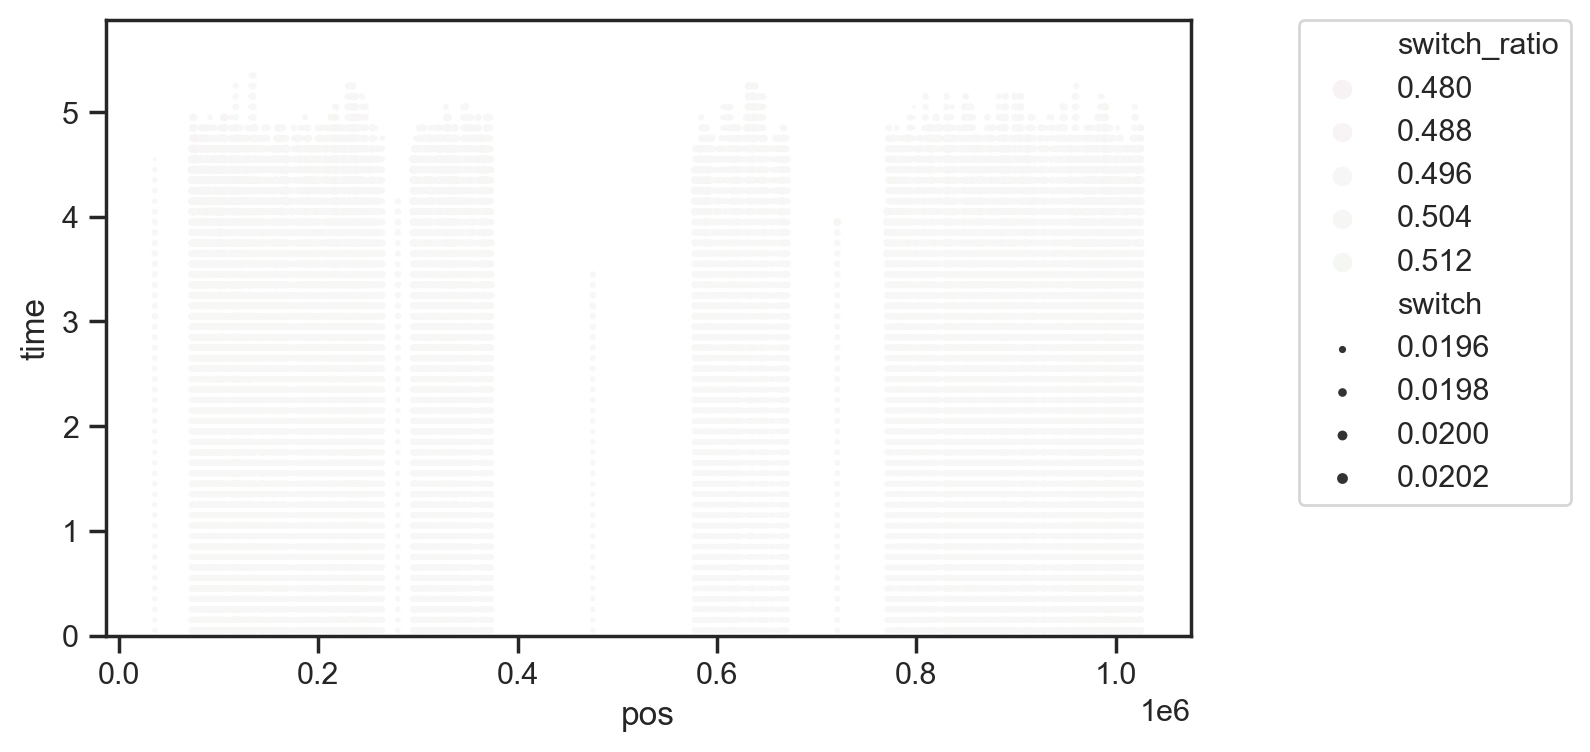

In [72]:
colors = sns.color_palette('PiYG', n_colors=10)
pink, green = colors[0], colors[-1]

with sns.color_palette('PiYG'), sns.axes_style('ticks'):
    fig, ax1 = plt.subplots(1, 1, figsize=(7,4))
    g = sns.scatterplot(data=plot_df, x='pos', y='time', hue='switch_ratio', size='switch',
        sizes=(1, 10), 
        palette='PiYG',
        hue_norm=(0, 1),
        ax=ax1, 
        legend='brief',
        linewidth=0        
         )
    ax1.set_ylim(0, 1.1*plot_df.time.max())  
    ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
       
    # ax2 = ax1.twinx()
    # ax2.plot(plot_df.pos, plot_df.mrca_0, '-x', color=pink, label='mrca 0')
    # ax2.plot(plot_df.pos, plot_df.mrca_1, '-x', color=green, label='mrca 1')
    # ax2.plot(plot_df.pos, plot_df.mrca_tree, '-x', color='black', label='mrca all')
    # ax2.set_ylim(0, 1.1*max(plot_df.mrca_tree.max(), plot_df.mrca_0.max(), plot_df.mrca_1.max()))
    # ax2.legend(bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0)




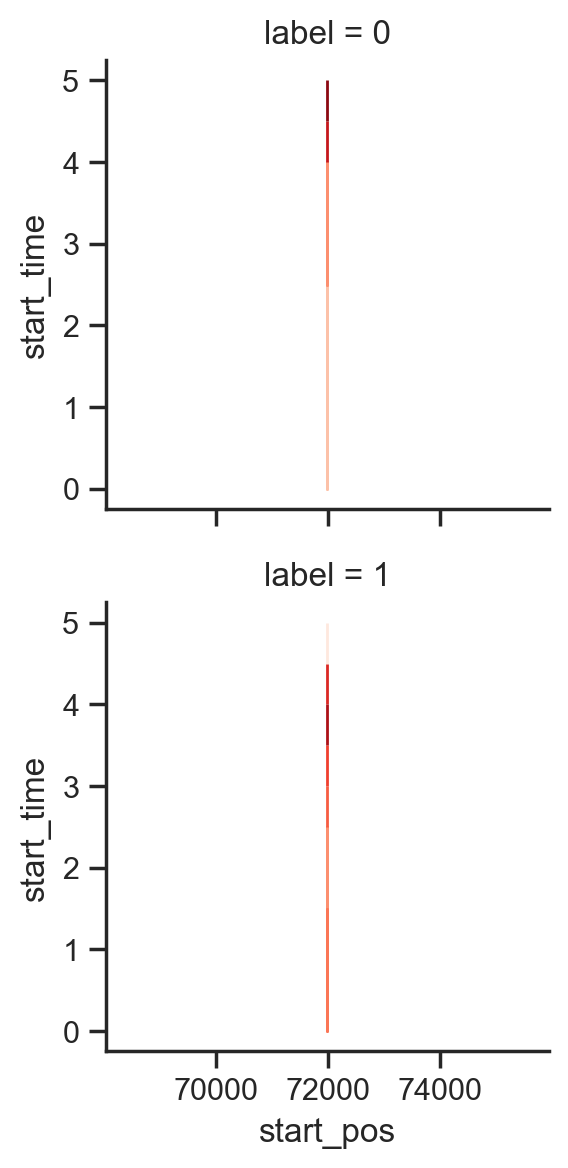

In [84]:
g = sns.FacetGrid(data=df, row='label', hue='switches', palette='Reds')
g.map(plt.fill_between, 'start_pos', 'start_time', 'end_time', label='label')

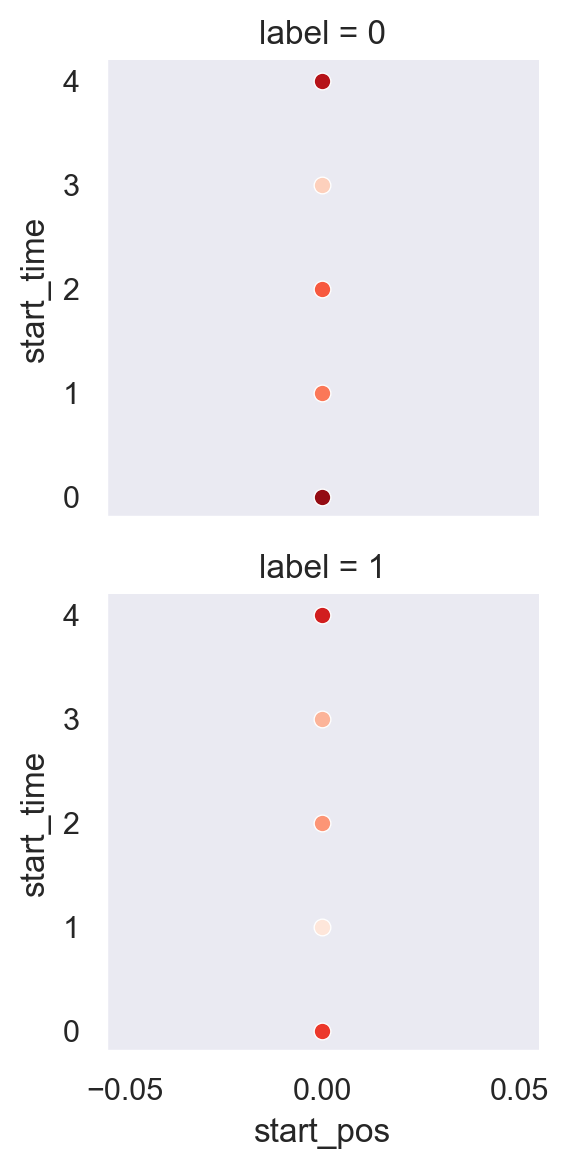

In [67]:
g = sns.FacetGrid(data=df, row='label', hue='switches', palette='Reds' )
g.map(sns.scatterplot, 'start_pos', 'start_time', label='label')

<AxesSubplot: xlabel='start_pos', ylabel='start_time'>

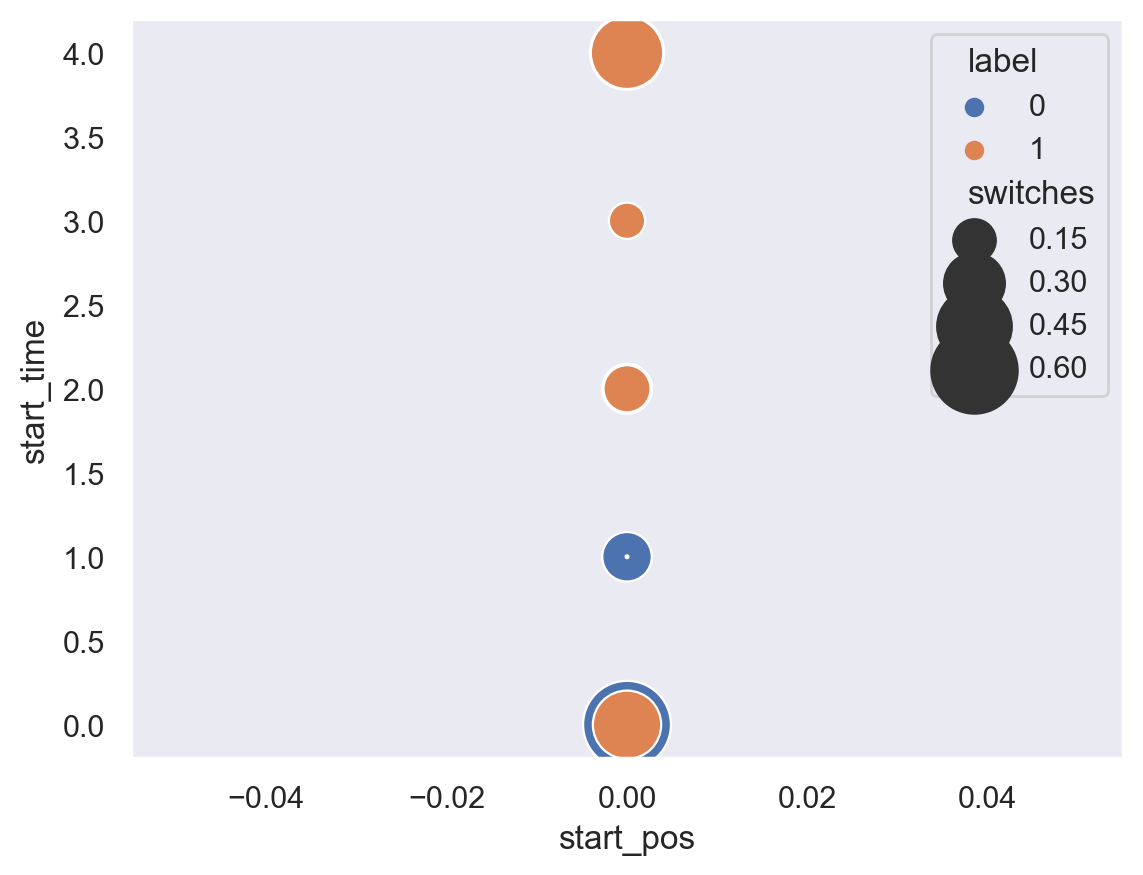

In [84]:
sns.scatterplot(data=df, x='start_pos', y='start_time', hue='label', size='switches',
sizes=(1, 1000), 
#hue_norm=(0, 7), 
#  legend="full"
 )

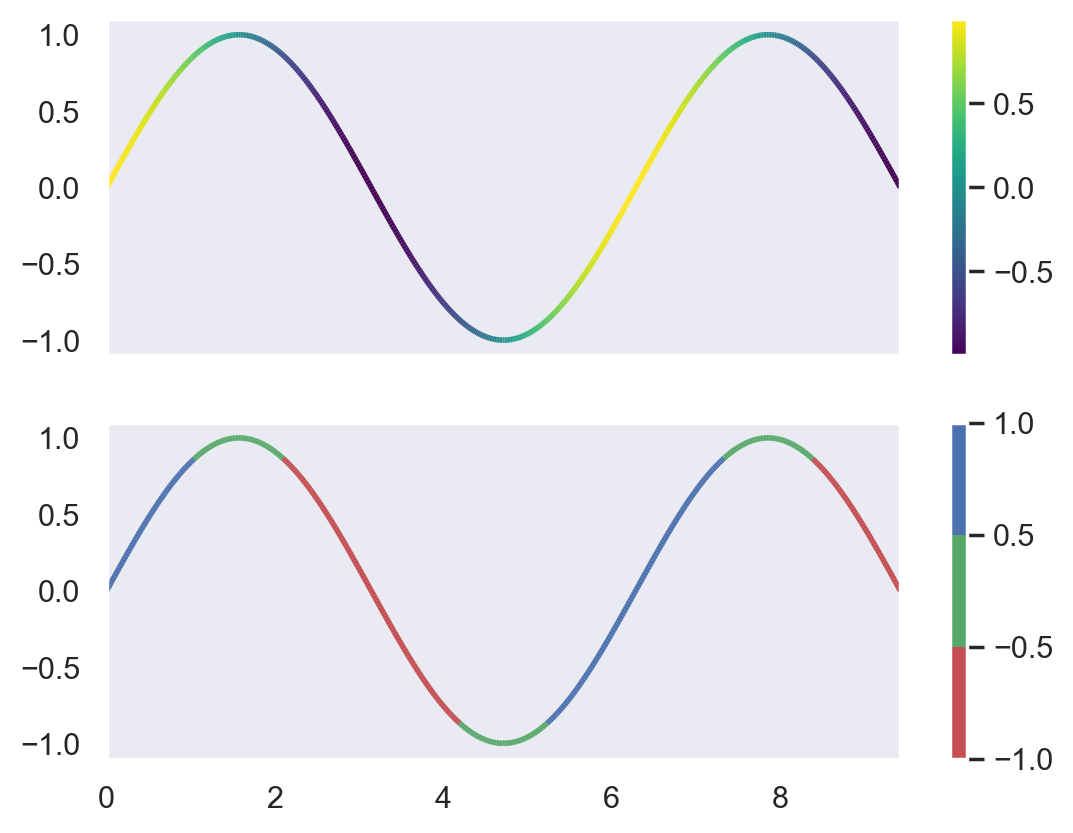

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()